Install script dependencies..

# Continious Achitecture Analyzer CAA

In [300]:
pip install -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [301]:
# notebook dependencies
import sys
import pathlib
from pathlib import Path
import re
import networkx as nx
import matplotlib.pyplot as plt

# Part 1: Analyze imports

In [302]:
# change to point to the right folder on your mahchine where you cloned the Zeeguu-Core
CODE_ROOT_FOLDER = 'code/'

# And a helper function to construct
# the full path of a file by adding the CODE_ROOT_FOLDER
def full_path(file_name):
    return CODE_ROOT_FOLDER+file_name

def LOC(file):
    return sum([1 for line in open(file)])

In [303]:
def extract_import_from_line(line):
    x = re.search("^import (\S+)", line)
    if(x == None):
        x = re.search("^from (\S+)", line)

    return x.group(1)

def imports(file):
    # extracts all the imported modules from a file
    lines = [line for line in open(file)]
    
    all_imports = []
    for line in lines:
        try:
            all_imports.append(extract_import_from_line(line))
        except:
            continue
            
    return all_imports

assert "requests" in imports(full_path('iot-grafana-user-creator/handler.py'))

In [304]:
def module_from_file_path(folder_prefix, full_path):
    # extracting a module from a file name
    # e.g. /Users/mircea/Zeeguu-Core/zeeguu_core/model/user.py -> zeeguu_core.model.user
    
    file_name = full_path[len(folder_prefix):]
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    
    return file_name

def module(full_path):
    return module_from_file_path(CODE_ROOT_FOLDER, full_path)

assert 'iot-grafana-user-creator.handler' == module(full_path('iot-grafana-user-creator/handler.py'))

In [305]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    
    G = nx.Graph()

    for file in files:
        m = module(str(file))

        if "template" not in str(file):
            if m not in G.nodes:
                G.add_node(m)
            for each in imports(str(file)):
                G.add_edge(m, each)

    return G

In [306]:
def top_level_module(module_name, depth=1):
    # extracts the parent of depth X 
    # e.g. top_level_module(zeeguu_core.model.util, 1) -> zeeguu_core
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_module("grafana-user-creator.helper") == "grafana-user-creator")
assert (top_level_module("grafana-user-creator.helper", 2) == "grafana-user-creator.helper")

In [307]:
def draw_graph_with_labels(G, figsize=(10,10)):
    plt.figure(figsize=figsize)
    nx.draw(G,with_labels=True)
    plt.show()

In [308]:
def system_module(m):
    return m.startswith('iot')

In [309]:
def abstracted_to_top_level(G):
    aG = nx.DiGraph()
    count = 0
    for each in G.edges():
        source = top_level_module(each[0])
        destination = top_level_module(each[1])
        if system_module(source) and system_module(destination):
            count = count + 1
            aG.add_edge(source, destination)
            
    if count == 0: 
        print("No dependencies amongst top level modules (prefix 'iot')")
        return None
    
    return aG

## Visualization: Imports

### Directed dependencies amongst internal top level modules

In [310]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
if(aG != None): 
    draw_graph_with_labels(aG, (5,5))

No dependencies amongst top level modules (prefix 'iot')



Due to this being microservice architecture, don't be alarmed with there is no graph above.




### Undirected dependencies amongst imports with weights

In [311]:
def module_size(m):
    size = 0
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    for file in files:
        module_name = module(str(file))
        if module_name.startswith(m + '.'):
            size += LOC(str(file))
            
    return size

print("Lines of code pr service:")
print("iot-grafana-user-creator", module_size("iot-grafana-user-creator"))
print("iot-influxdb-savedata", module_size("iot-influxdb-savedata"))
print("iot-mqtt-interceptor", module_size("iot-mqtt-interceptor"))

Lines of code pr service:
iot-grafana-user-creator 101
iot-influxdb-savedata 86
iot-mqtt-interceptor 55


In [312]:
def draw_graph_with_weights(G, weight_function, figsize=(10,10)):
    node_weights = [weight_function(each)*10 for each in G.nodes]
    
    plt.figure(figsize=figsize)
    nx.draw(G,
            with_labels=True,
            node_size=node_weights)
    plt.show()

In [313]:
def abstracted_to_top_level(G):
    aG = nx.Graph()
    for each in G.edges():
        aG.add_edge(top_level_module(each[0]),
                    top_level_module(each[1]))

    return aG

### Graph: Undirected import dependencies 

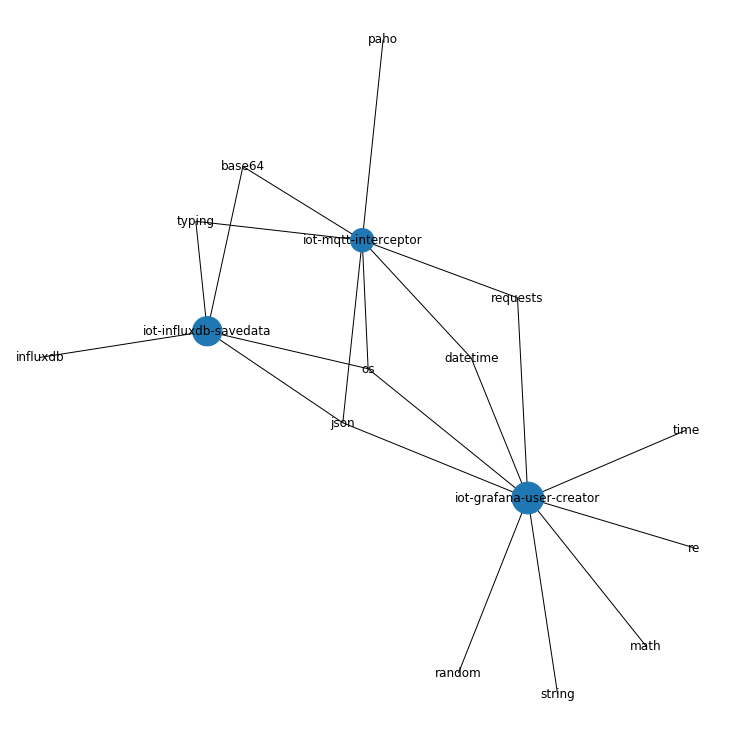

In [314]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
if(directedAbstracted != None): 
    draw_graph_with_weights(directedAbstracted, module_size, (10,10))

This diagram shows multiple things:

    The size of the micro service is imitiatly visible (for internal modules), so care can be taken if one grows too large

    Identical services are grouped together, if we deem sercices similar if they have the same dependencis. The more semilar, the tighter they are grouped due to this actually being a chemistry representation, i wont go into detail.
    
    Shows our services, and the dependencies required to perform dynamic analysis.
    
    
    
 


### Directed dependencies amongst imports with weights

In [315]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    
    G = nx.DiGraph()

    for file in files:
        m = module(str(file))

        if "template" not in str(file):
            if m not in G.nodes:
                G.add_node(m)
            for each in imports(str(file)):
                G.add_edge(m, each)

    return G

In [316]:
def abstracted_to_top_level(G):
    aG = nx.DiGraph()
    for each in G.edges():
        aG.add_edge(top_level_module(each[0]),
                    top_level_module(each[1]))

    return aG

### Graph: Directed import dependencies

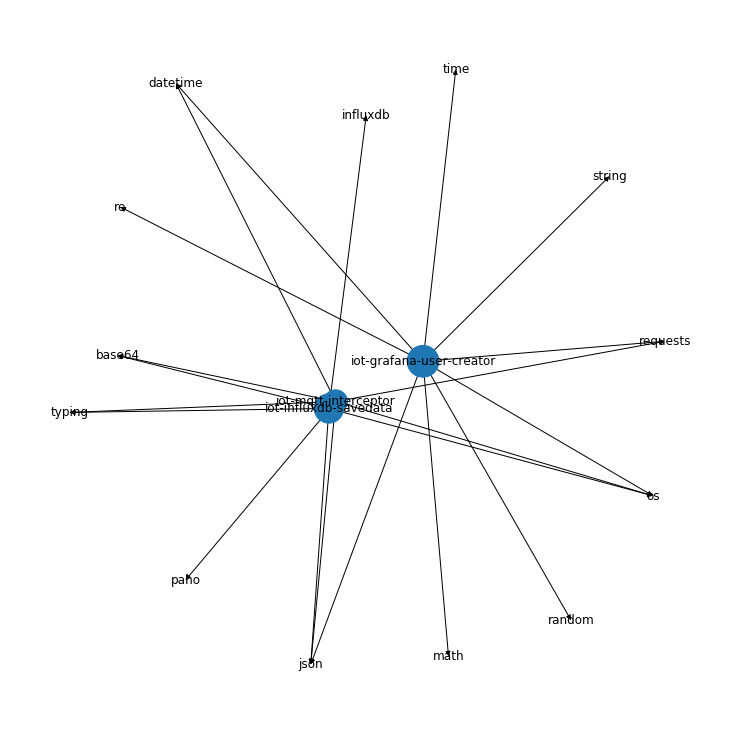

In [317]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
if(directedAbstracted != None): 
    draw_graph_with_weights(directedAbstracted, module_size, (10,10))

This diagram is also interresting, but less usefull than the undirected version

# External services

In the following section we will determine the external dependencies of the OpenFaas functions in the repository. 

A service is either a program running in a container, or a function as described in the report.

## Analyzing OpenFaas functions

#### Environment variables 

In [318]:
def extract_env_from_line(line):
    x = re.search("(\w)*:(\w)*", line)
    if x != None: 
        var_name = line.split(": ")[0].strip()
        var_dec = line.split(": ")[1].strip()

    return (var_name, var_dec)

In [319]:
# replaces occourences of env_var with actual value
def map_env_vars_openfaas(handler, env_vars):
    print("Parsing", "'" + handler + "'", "and replacing variables...")
    lines = [line for line in open(handler)]
    
    all_vars = []
    for line in lines:
        try:
            for (k, v) in env_vars:
                if k in line:
                    print("Replacing", "os.getenv(\"" + k + "\")", "with", v)
                    line = line.replace("os.getenv(\"" + k + "\")", v, 1)
                
            all_vars.append(line)
        except:
            continue
            
    return all_vars

# find env_vars in the yml
def get_env_vars_openfaas(yml):
    print("Parsing", "'" + yml + "'", "for environment variables...")
    lines = [line for line in open(yml)]
    
    all_vars = []
    for line in lines:
        try:
            # skip attributes we don't care about for now
            if 'image' in line:
                continue
            if 'name' in line:
                continue
            if 'lang' in line:
                continue
            if 'handler' in line:
                continue
            if 'version' in line: 
                continue
                
            all_vars.append(extract_env_from_line(line))
            
        except:
            continue
        
    print("Environment variables:", all_vars)
    return all_vars

def get_program_text_with_env_openfaas(yml, handler):
    env_vars = get_env_vars_openfaas(full_path(yml))
    return map_env_vars_openfaas(full_path(handler), env_vars)


This returns a map with the env variables.

At this point the code contains the variables otherwise normally only obtianed at runtime. Lets see if we can figure out which external services the service is communicating with.

#### Replace environment variables in code, and extract correct values from code

In [320]:
def extract_urls_from_line(line):
    # filter initial source code lines so only one with variables remains
    matching = re.search("(https?:\/\/(.)*)", line)
    
    if matching != None or 'ec2' in line: # not https?:// format, or contains ec2 for aws
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()
        
        # refine if not composite variable
        if '+' not in line: 
            y = re.search("((https?:\/\/)?[-\w.]*(\.\w{2,3}(:?[\d]{2,6})?))", line)
            if y.group(1) != None: 
                var_dec = y.group(1)

        print("    >", var_name, var_dec)

    return (var_name, var_dec)

def find_external_services(program):
    lines = [line for line in program]
    
    services = []
    for line in lines:
        try:
            # extract lines with urls
            services.append(extract_urls_from_line(line))
        except:
            continue
    
    print()
    print("Found", len(services), "external services")
    return services


def interpret_service_strings(env_vars):
    interpreted = []
    for line in env_vars:
        try:
            for (k, v) in env_vars:
                if k in line[1]:
                    print("Replacing", k, "with", v)
                    # clean up string
                    tmp = line[1].replace(k, v, 1)
                    tmp = tmp.strip().replace("'", "")
                    tmp = tmp.replace("+", "")
                    res = tmp.replace(" ", "")

            # only modified values
            interpreted.append((line[0], res))
            
        except:
            continue
            
    print("Changed", len(interpreted), "values by substitution", "\n")
    return interpreted


def analyse_external_services(yml, handler):
    services = find_external_services(
        get_program_text_with_env_openfaas(
            yml, 
            handler))
    
    changed = interpret_service_strings(services)

    # combine lists to one, or return env if no changes
    if len(changed) > 0:
        list1, list2 = zip(*changed)
        for(k,v) in services:
            if k in list1:
                continue
            else: 
                changed.append((k, v))
        return changed

    else: 
        return services


def analyze_grafana():
    print()
    print("Analysing IOT-Grafana-user-creator...\n")
    external_dependencies_grafana = analyse_external_services('iot-grafana-user-creator/iot-assignment2.yml', 'iot-grafana-user-creator/handler.py')
    print("Results for IOT-Grafana-user-creator:")
    for (k,v) in external_dependencies_grafana:
        print("  ", k+":", v)

    print()
    print()
    return external_dependencies_grafana

def analyze_influxdb():
    print()
    print("Analyzing IOT-InfluxDB-SaveData...\n")
    external_dependencies_influx = analyse_external_services('iot-influxdb-savedata/iot-assignment2.yml', 'iot-influxdb-savedata/handler.py')
    print("Results for IOT-InfluxDB-SaveData:")
    for (k,v) in external_dependencies_influx:
        print("  ", k+":", v)

    print()
    print()
    return external_dependencies_influx


external_dependencies_grafana = analyze_grafana()
print()
external_dependencies_influx = analyze_influxdb()


Analysing IOT-Grafana-user-creator...

Parsing 'code/iot-grafana-user-creator/iot-assignment2.yml' for environment variables...
Environment variables: [('gateway', 'https://gateway.christoffernissen.me'), ('host', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000')]
Parsing 'code/iot-grafana-user-creator/handler.py' and replacing variables...
Replacing os.getenv("host") with ec2-34-226-215-115.compute-1.amazonaws.com:3000
    > HOST ec2-34-226-215-115.compute-1.amazonaws.com:3000
    > URL_USERS 'http://admin:smartmeter@' + HOST + '/api/admin/users'
    > URL_DASHBOARD 'http://' + HOST + '/api/dashboards/db'
    > URL_DASHBOARD_PERMISSIONS 'http://' + HOST + '/api/dashboards/id/%s/permissions'
    > URL_CUSTOMERS_TEAM_MEMBERS 'http://' + HOST + '/api/teams/10/members'

Found 5 external services
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws.com:3000
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws.com:3000
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws

Now we have an overview of the OpenFaas functions. In the following section the same will be calculated for the docker container service MQTT-Interceptor. 

Finally, we will visualize the different services, and the links between services.

## Analyzing Docker service

In [321]:
def extract_env_from_line_docker(line):
    x = re.search("(\w)*=(\w)*", line)
    if x != None: 
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()

    return (var_name, var_dec)

In [322]:
def map_env_vars_docker(handler, env_vars):
    print("Parsing", "'" + handler + "'", "and replacing variables...")
    lines = [line for line in open(handler)]
    
    all_vars = []
    for line in lines:
        try:
            for (k, v) in env_vars:
                if k in line:
                    if 'os.getenv' in line: 
                        print("    Replacing", "os.getenv(\"" + k + "\")", "with", v)
                        line = line.replace("os.getenv(\"" + k + "\")", v, 1)
                    else: 
                        print("    Replacing", k, "with", v)
                        line = line.replace(k, v, 1)
                        line.replace("+", "")
                          
                all_vars.append(line)
        except:
            continue
            
    return all_vars


def get_env_vars_docker(env):
    print("Parsing", "'" + env + "'", "for environment variables...\n")
    lines = [line for line in open(env)]
    
    all_vars = []
    for line in lines:
        try:
            all_vars.append(extract_env_from_line_docker(line))
            
        except:
            continue
        
    print("Environment variables:\n", all_vars)
    return all_vars


def get_program_text_with_env_docker(env, code):
    env_vars = get_env_vars_docker(full_path(env))
    return map_env_vars_docker(full_path(code), env_vars)

at this point we have modified the source code so it now is substituted with env vars

In [323]:
def extract_urls_from_line_docker(line):
    # filter initial source code lines so only one with variables remains
    x = re.search("(https?:\/\/(.)*)", line)
    
    if x != None or 'ec2' in line: 
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()
        
        # refine if not composite variable
        if '+' not in line: 
            y = re.search("((https?:\/\/)?[-\w.]*(\.\w{2,3})(:[\d]{4})?)", line)
            if y.group(1) != None: 
                var_dec = y.group(1)
                
    return (var_name, var_dec.replace("+", " ").replace(" ", "").replace("\"", ""))


def find_external_services_docker(program):
    lines = [line for line in program]
    
    services = []
    for line in lines:
        try:
            services.append(extract_urls_from_line_docker(line))
        except:
            continue
    
    print()
    print("Found", len(services), "external services\n")
    return services


def analyse_external_services_docker(yml, handler):
    mod_program = get_program_text_with_env_docker(
            yml, 
            handler)
    
    return find_external_services_docker(mod_program)

def analyze_mqtt():
    print()
    print("IOT-MQTT-INTERCEPTOR")
    external_dependencies_mqtt = analyse_external_services_docker('iot-mqtt-interceptor/env_vars', 
                'iot-mqtt-interceptor/app.py')
    print("Results:")
    for (k,v) in external_dependencies_mqtt:
        print("  ", k+":", v)

    # now we have all external dependencies, including our own functions. Lets identify those:

    funcs = []
    print("Identified following dependencies on OpenFaas Functions")
    for (k,v) in external_dependencies_mqtt:
        if '/function/' in v:
            func = v.split("/")[len(v.split("/"))-1]
            print("  ", func)
            funcs.append(func)

    print()
    print()
    return external_dependencies_mqtt

external_dependencies_mqtt = analyze_mqtt()


IOT-MQTT-INTERCEPTOR
Parsing 'code/iot-mqtt-interceptor/env_vars' for environment variables...

Environment variables:
 [('gateway_url', 'https://gateway.christoffernissen.me')]
Parsing 'code/iot-mqtt-interceptor/app.py' and replacing variables...
    Replacing os.getenv("gateway_url") with https://gateway.christoffernissen.me
    Replacing os.getenv("gateway_url") with https://gateway.christoffernissen.me

Found 1 external services

Results:
   function_url: https://gateway.christoffernissen.me/function/iot-influxdb-savedata
Identified following dependencies on OpenFaas Functions
   iot-influxdb-savedata




Puhhh. Thats it. We have identified the external dependencies, and also identifed our our functions. We can now use the information to graw diagrams. 

OpenFaas functions will be represented as nodes with the directory name, and non-OpenFaas dependencies will just be mapped to a node where the nodes label is the value, and the edge label is the env var name. 

## Visualization of external dependencies

### Summary of analysis

In [324]:
analyze_grafana()

analyze_influxdb()

analyze_mqtt()


Analysing IOT-Grafana-user-creator...

Parsing 'code/iot-grafana-user-creator/iot-assignment2.yml' for environment variables...
Environment variables: [('gateway', 'https://gateway.christoffernissen.me'), ('host', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000')]
Parsing 'code/iot-grafana-user-creator/handler.py' and replacing variables...
Replacing os.getenv("host") with ec2-34-226-215-115.compute-1.amazonaws.com:3000
    > HOST ec2-34-226-215-115.compute-1.amazonaws.com:3000
    > URL_USERS 'http://admin:smartmeter@' + HOST + '/api/admin/users'
    > URL_DASHBOARD 'http://' + HOST + '/api/dashboards/db'
    > URL_DASHBOARD_PERMISSIONS 'http://' + HOST + '/api/dashboards/id/%s/permissions'
    > URL_CUSTOMERS_TEAM_MEMBERS 'http://' + HOST + '/api/teams/10/members'

Found 5 external services
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws.com:3000
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws.com:3000
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws

[('function_url',
  'https://gateway.christoffernissen.me/function/iot-influxdb-savedata')]

### Mapping rules

nodes = urls
edges = env_var names

weight to indicate internal service

In [325]:
# 3 services, add as nodes

# 3 lists of tuples

# for each service, 1 list of tuples

# for each item in list, (k,v)

# if v is function, add edge from service to function node
# else 
    # add new node with label = v
    # add edge from service -> node

def base_graph():
    G = nx.MultiDiGraph()
    
    G.add_node('iot-mqtt-interceptor')
    G.add_node('iot-influxdb-savedata')
    G.add_node('iot-grafana-user-creator')
    
    return G
    
labels = []
def dependencies_graph(G, list, current_func):
    for (k, v) in list:
        if 'function' in v: 
            func = v.split("/")[len(v.split("/"))-1]
            
            if func.lower() not in G.nodes:
                G.add_node(func)
                G.add_edge(current_func, func.lower())
            else: 
                # already there because base graph, add edge
                G.add_edge(current_func, func.lower())

        else:
            if k not in G.nodes:
                # extract common identifer from url
                
                # top level external identifier
                y = re.search("([\d\w-]*):?['.'][\w]{2,3}", v)
                G.add_node(y.group())
                
                G.add_edge(current_func, y.group())
                
                labels.append(((current_func, y.group()), k))
                
    return G
    
g0 = base_graph()
g1 = dependencies_graph(g0, external_dependencies_mqtt, 'iot-mqtt-interceptor')
g2 = dependencies_graph(g1, external_dependencies_grafana, 'iot-grafana-user-creator')
g3 = dependencies_graph(g2, external_dependencies_influx, 'iot-influxdb-savedata')

### Graph directed weighted external dependencies

In [326]:
def draw_graph_with_weights(G, weight_function, figsize=(10,10)):
    node_weights = [weight_function(each)*10 for each in G.nodes]
    
    plt.figure(figsize=figsize)
    
    print("Labels prepared, but couldnt insert in graph")
    print(labels)
    
    nx.draw(G,
            with_labels=True,
            edge_labels=labels,
            node_size=node_weights)


Labels prepared, but couldnt insert in graph
[(('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'URL_USERS'), (('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'URL_DASHBOARD'), (('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'URL_DASHBOARD_PERMISSIONS'), (('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'URL_CUSTOMERS_TEAM_MEMBERS'), (('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'HOST'), (('iot-influxdb-savedata', 'ec2-34-226-215-115.com'), 'INFLUXDB_ADDRESS')]


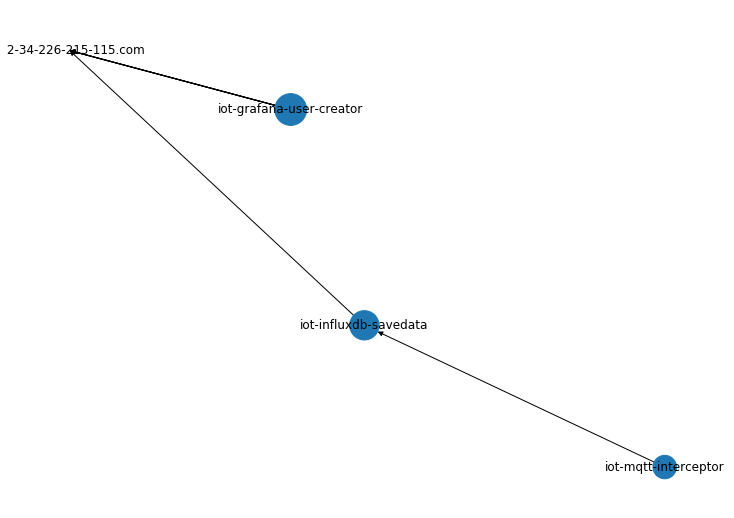

In [327]:
draw_graph_with_weights(g3, module_size, (10,7))

Here we are, the allocation viewpoint, sorta
    
    Observe a chain with iot-mqtt-interceptor -> iot-influxdb-savedata -> INFLUXDB_ADDRESS
    
    External dependencies required at runtime

In [329]:
labels = []
def dependencies_graph(G, list, current_func):
    for (k, v) in list:
        if 'function' in v: 
            func = v.split("/")[len(v.split("/"))-1]
            
            if func.lower() not in G.nodes:
                G.add_node(func)
                G.add_edge(current_func, func.lower())
            else: 
                # already there because base graph, add edge
                G.add_edge(current_func, func.lower())

        else:
            if k not in G.nodes:
                # extract common identifer from url
                
                # top level external identifier
                y = re.search("([\d\w-]*):?['.'][\w]{2,3}", v)
                G.add_node(y.group())
                
                G.add_edge(current_func, y.group()+v.split(y.group())[1])
                
                labels.append(((current_func, y.group()), k))
                
    return G
    
g0 = base_graph()
g1 = dependencies_graph(g0, external_dependencies_mqtt, 'iot-mqtt-interceptor')
g2 = dependencies_graph(g1, external_dependencies_grafana, 'iot-grafana-user-creator')
g3 = dependencies_graph(g2, external_dependencies_influx, 'iot-influxdb-savedata')

### Graph: All external communication

Labels prepared, but couldnt insert in graph
[(('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'URL_USERS'), (('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'URL_DASHBOARD'), (('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'URL_DASHBOARD_PERMISSIONS'), (('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'URL_CUSTOMERS_TEAM_MEMBERS'), (('iot-grafana-user-creator', 'ec2-34-226-215-115.com'), 'HOST'), (('iot-influxdb-savedata', 'ec2-34-226-215-115.com'), 'INFLUXDB_ADDRESS')]


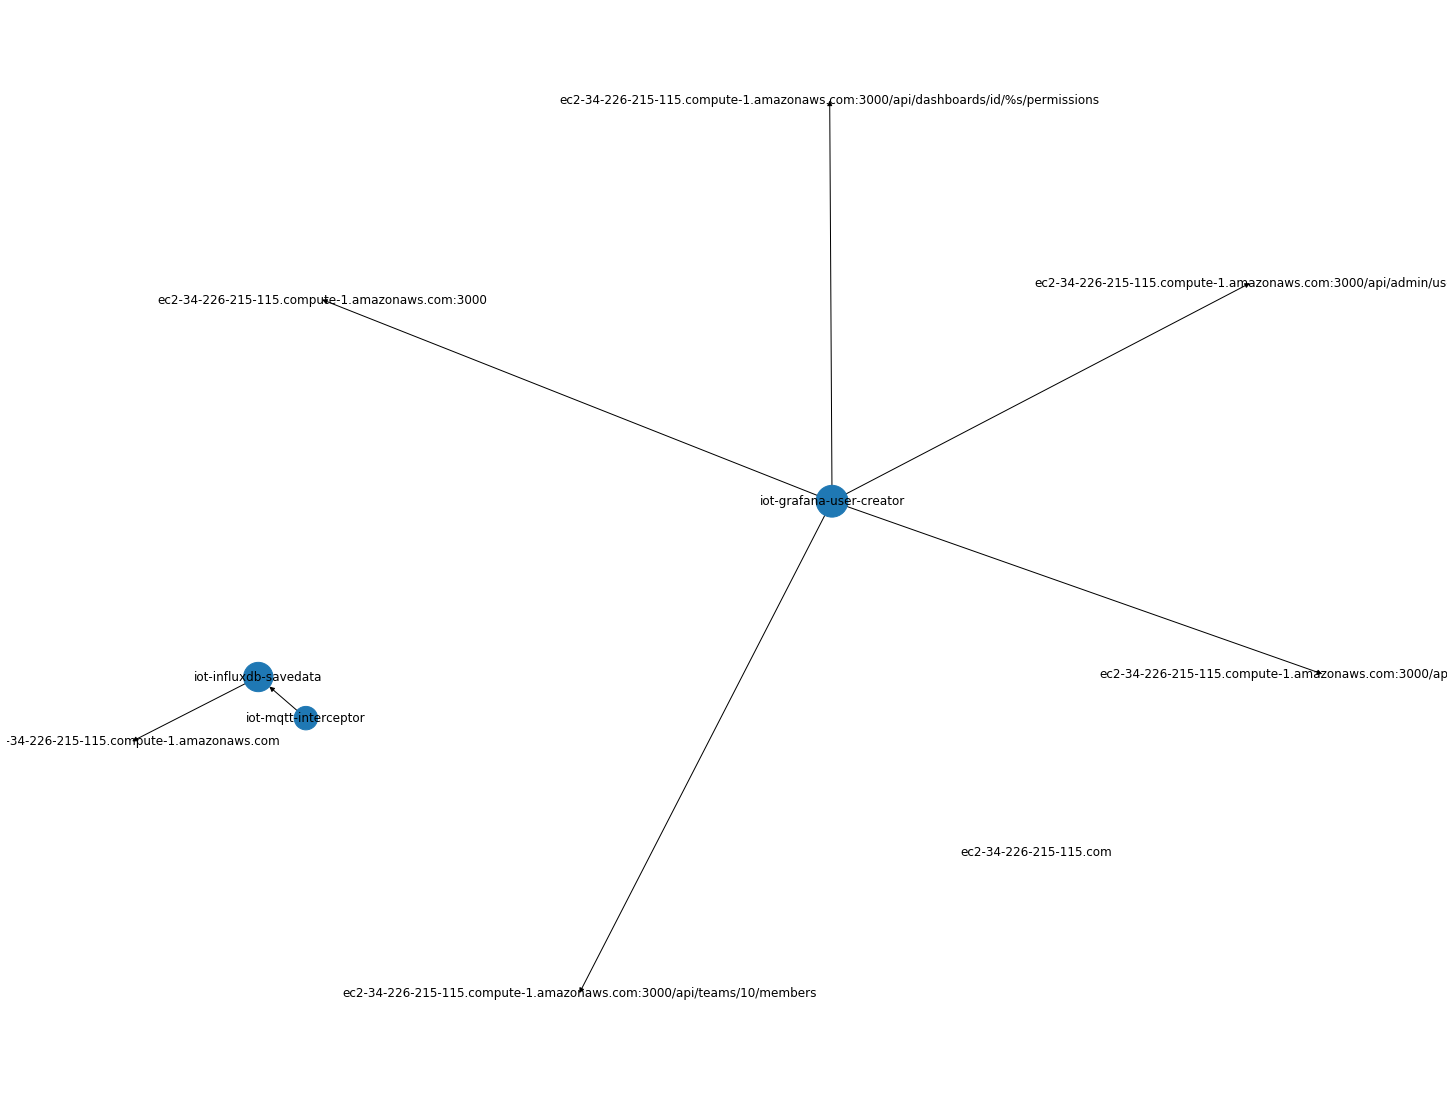

In [337]:
draw_graph_with_weights(g3, module_size, (20,15))

### Future improvements

If everything had gone according to plan, we would also see a graph here with multiple edges between two nodes, so map multiple different connections to the same machine, to get a better overview over allocation, than what is currently provided in either of the graphs presented last.